# Characterization of Alzheimer's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime, date
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-l312fxi3 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Data Pre-processing

#### Exploring the data

In [30]:
path = "data/Early-onset.csv"
df = pd.read_csv(path)
df

,person_id,birth_datetime,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
1,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...
2,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
3,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
4,271,1932-02-09 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. Moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,X-ray abdomen complete with chest Indication: ...
26183,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26184,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26185,258985,1946-12-18 00:00:00,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,Study: AP radiograph of the chest History: Wea...


### Calculating the age of each patient from their birth date

In [31]:
# Converting the "birth_datetime" column to a datetime format 
df["birth_datetime"] = pd.to_datetime(df["birth_datetime"], format='%Y-%m-%d')
# Calculating the age by substracting the current date with the date in the dataframe
df["age"] = (pd.Timestamp('now') - df["birth_datetime"]).astype('timedelta64[Y]')
# Converting age to integer
df["age"]  = pd.to_numeric(df["age"], downcast='integer')
# Dropping the birth_datetime (it's useless at this point) 
df = df.drop("birth_datetime", axis=1)
# Re-arranging the order of the columns
df = df[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'note_title', 'note_text']]
df

,person_id,age,gender_source_value,race_source_value,ethnicity_source_value,note_title,note_text
0,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
1,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...
2,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
3,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,No acute osseous abnormality of the right shou...
4,271,90,FEMALE,WHITE,NOT HISPANIC,order_impression: IMAGING,1. Moderate subcutaneous hematoma about the le...
...,...,...,...,...,...,...,...
26182,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,X-ray abdomen complete with chest Indication: ...
26183,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26184,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,CTA dissection protocol. Technique: Axial imag...
26185,258985,75,FEMALE,WHITE,NOT HISPANIC,order_narative: IMAGING,Study: AP radiograph of the chest History: Wea...


### Creating the corpus from medical notes 

In [32]:
corpus = list(df["note_text"])

### Creating Text embeddings

In [33]:
model = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

No sentence-transformers model found with name ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

#### Some model parameters

The Transformer itself has a max sequence length of 512 tokens and it does not lowercase the input. For the pooling operation we will produce a 768-dimensional sentence embedding. We do this using mean pooling 

In [34]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [35]:
embeddings = model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/819 [00:00<?, ?it/s]

In [36]:
embeddings

array([[-0.01031036, -0.30022842, -0.0040418 , ...,  0.16678289,
        -0.06362955, -0.1038893 ],
       [ 0.24206898, -0.12554152, -0.11126488, ...,  0.1350423 ,
        -0.07171026, -0.21101828],
       [-0.01031036, -0.30022842, -0.0040418 , ...,  0.16678289,
        -0.06362955, -0.1038893 ],
       ...,
       [ 0.16683355, -0.24268997,  0.01422041, ...,  0.2329206 ,
        -0.12016237, -0.09765943],
       [ 0.04199807, -0.34661102, -0.08677702, ...,  0.26763746,
         0.03535613, -0.15291375],
       [ 0.16683355, -0.24268997,  0.01422041, ...,  0.2329206 ,
        -0.12016237, -0.09765943]], dtype=float32)

In [37]:
embeddings.shape[0]

26187

### Clustering with K-means

In [61]:
num_clusters = 10
cluster = KMeans(n_clusters=num_clusters)
cluster.fit(embeddings)
cluster_assignment = cluster.labels_

### Taking a look at the different categories

In [62]:
cluster_assignment

array([3, 3, 3, ..., 1, 0, 1], dtype=int32)

#### Putting the notes with their clusters for better visualization

In [63]:
df_corpus = pd.DataFrame({"Corpus": corpus, "Cluster": cluster_assignment})
df_corpus

,Corpus,Cluster
0,No acute osseous abnormality of the right shou...,3
1,FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...,3
2,No acute osseous abnormality of the right shou...,3
3,No acute osseous abnormality of the right shou...,3
4,1. Moderate subcutaneous hematoma about the le...,7
...,...,...
26182,X-ray abdomen complete with chest Indication: ...,0
26183,CTA dissection protocol. Technique: Axial imag...,1
26184,CTA dissection protocol. Technique: Axial imag...,1
26185,Study: AP radiograph of the chest History: Wea...,0


### Data Visualization

In [64]:
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in df_corpus['Corpus'][df_corpus['Cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

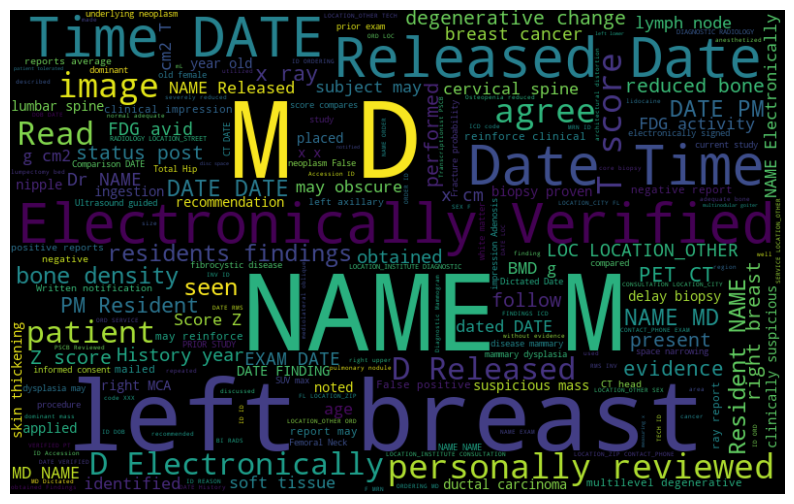

In [65]:
word_cloud(df_corpus,0)

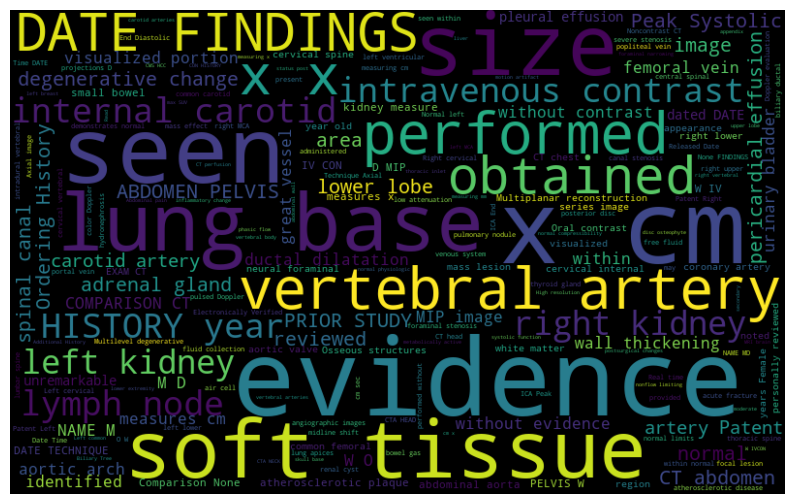

In [66]:
word_cloud(df_corpus,1)

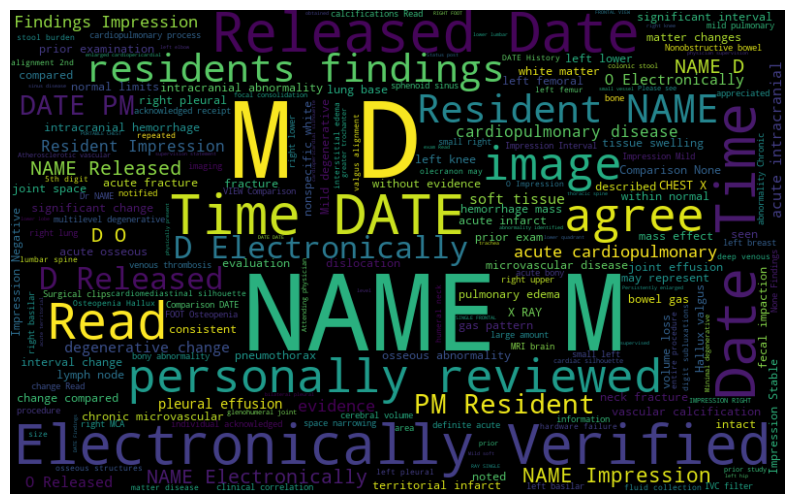

In [67]:
word_cloud(df_corpus,2)

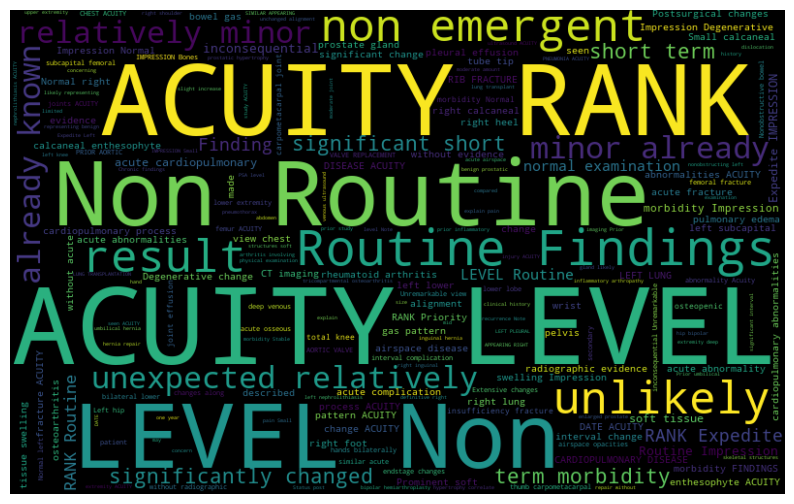

In [68]:
word_cloud(df_corpus,3)

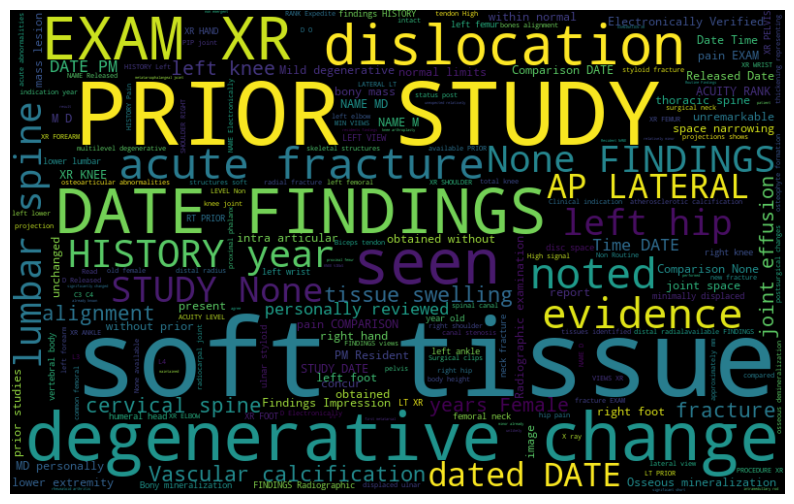

In [69]:
word_cloud(df_corpus,4)

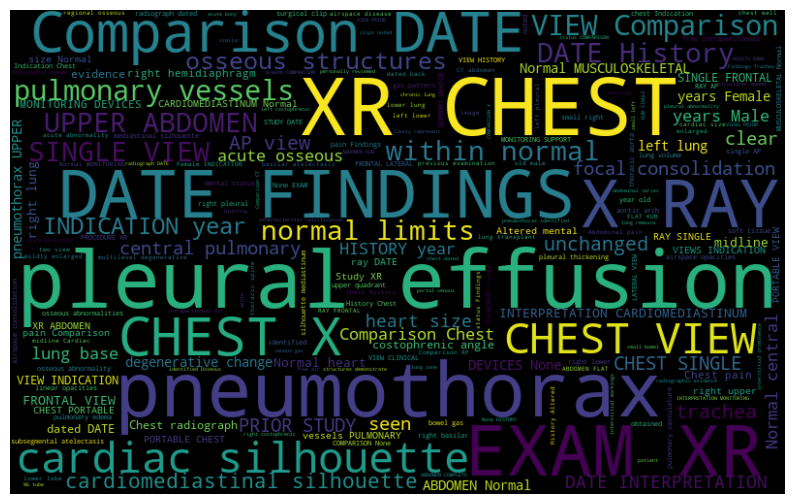

In [70]:
word_cloud(df_corpus,5)

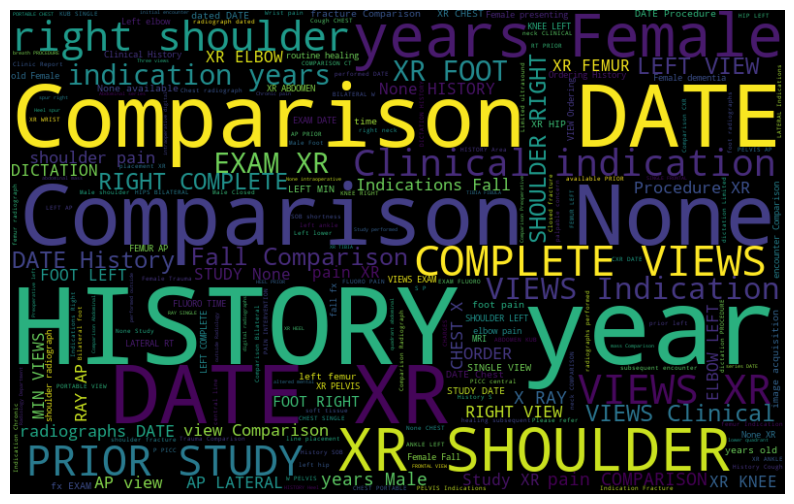

In [71]:
word_cloud(df_corpus,6)

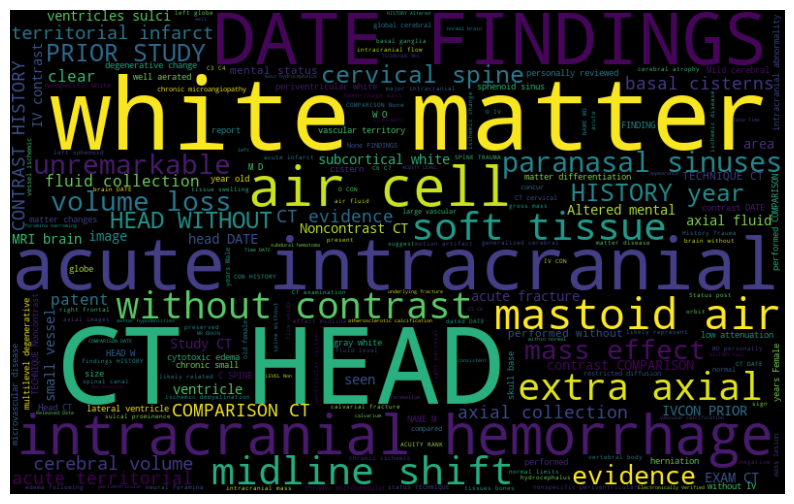

In [73]:
word_cloud(df_corpus,7)

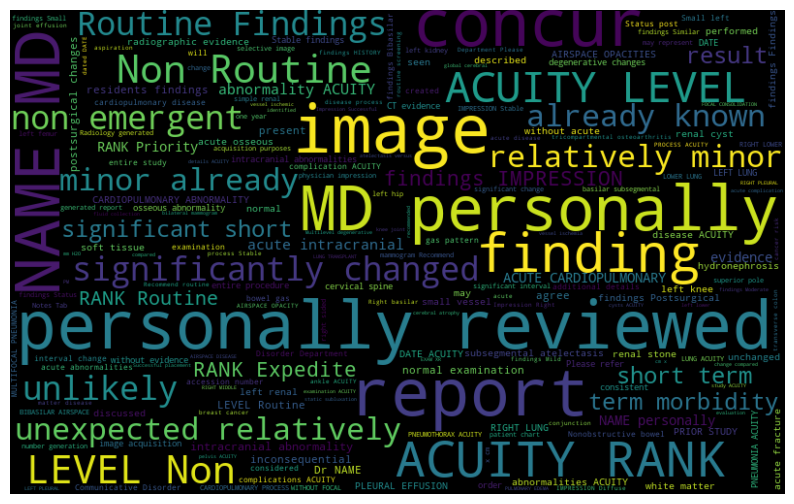

In [74]:
word_cloud(df_corpus,8)

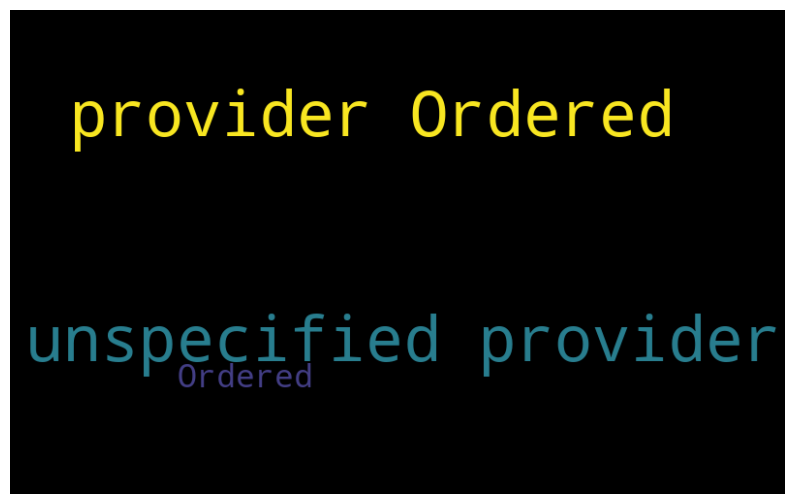

In [75]:
word_cloud(df_corpus,9)